In [1]:
# The idea is to do a simple linear model of non-linear interactions between basic statistics. We will motivate these
# interactions based on some intuitions. For example, (mean / std) should influence the forecasting ability 
# different statistics, i.e. look at (mean / std) * mean. However, we do this for windows.

# A better basis is based on using r_i = (mean_window_i / mean_all) or r_i = (mean_window_i / (epsilon + mean_all)).
# Normally, one could estimate using the average of the mean_window_i (or some weighted average). However, when 
# r_i is large, one wants to replace mean_window_i by mean_all. So we are lead to trying basis functions such as
# f_i = exp(-K_i * r_i) * mean_window_i + (1 - exp(-K_i * r_i)) * mean_all, where K_i is a constant parameter that
# can be adjusted. First try finding optimal K_i that increase linear correlation between Y_mean and f_i.
# Also can try using logit functions of r_i or some other functions that is suggestive of a neural network.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

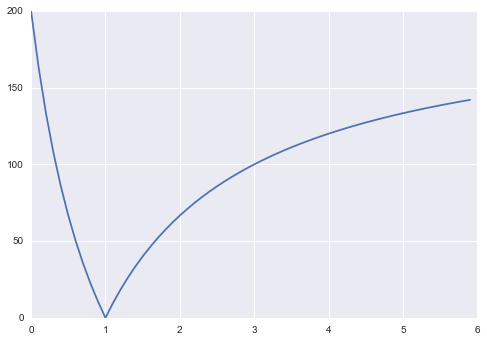

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [211]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

def window_features(X, nWindows = 2, windowSize = 64):
    nSamples, nFeatures = X.shape
    # Make a view from X that is a 3d array of size (nSamples, windowSize, nWindows). This gives a view
    # of each window in X.
    X_window = nFeatures - 1 - np.arange(windowSize)[:, np.newaxis] - windowSize * np.arange(nWindows)
    X_window = X[:, X_window]
    
    # Now extract features for X and for each window.
    all_mean = np.mean(X, axis = 1, keepdims = True)
    features = all_mean.copy()
    newCols = np.mean(X_window, axis = 1) # window means
    features = np.hstack((features, newCols))
    
    return features

def window_weights(all_mean, window_means, k = 0.4, epsilon = 1e-6):
    weights = window_means / (epsilon + all_mean)
    weights = np.exp(-k * weights)
    return weights
    
def all_features(X, nWindows = 2, windowSize = 240, k = 0.4, epsilon = 1e-4):
    nSamples, nTimes = X.shape
    windFeatures = window_features(X, nWindows, windowSize)
    weights = window_weights(windFeatures[:,0].reshape(-1,1), windFeatures[:, 1:1+nWindows], k, epsilon)
    weightedFeatures = windFeatures[:, :, np.newaxis] * weights[:, np.newaxis, :]
    weightedFeatures = weightedFeatures.reshape(nSamples, -1)
    windFeatures = np.hstack((windFeatures, weightedFeatures))
    return windFeatures

In [153]:
# Look at feature data.

newFeatures = window_features(X_train)
weights = window_weights(newFeatures[:, 0].reshape(-1,1), newFeatures[:, 1:3])
allFeatures = all_features(X_train)
print('newFeatures.shape = ', newFeatures.shape, '\tweights.shape = ', weights.shape, '\tallFeatures.shape = ', allFeatures.shape)

newFeatures.shape =  (65118, 3) 	weights.shape =  (65118, 2) 	allFeatures.shape =  (65118, 9)


(97192, 6)


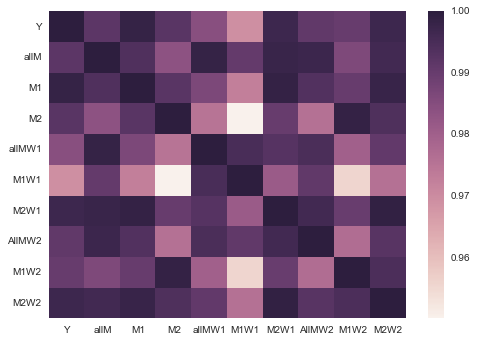

In [209]:
# Let's look at linear correlations.
nSamples, nTimes = X_trainvalid.shape
Y_mean = Y_trainvalid.mean(axis = 1, keepdims = True)
newFeatures = window_features(X_trainvalid)
weights = window_weights(newFeatures[:, 0].reshape(-1,1), newFeatures[:, 1:3])
weightFeatures = newFeatures[:, :, np.newaxis] * weights[:, np.newaxis, :]
weightFeatures = weightFeatures.reshape((nSamples, -1))
print(weightFeatures.shape)
corr_vars = np.hstack((Y_mean, newFeatures, weightFeatures)).T
corr_names = ['Y', 'allM', 'M1', 'M2', 'allMW1', 'M1W1', 'M2W1', 'AllMW2', 'M1W2', 'M2W2']
corr_matrix = np.corrcoef(corr_vars)
sns.heatmap(corr_matrix, xticklabels = corr_names, yticklabels = corr_names)
plt.show()

In [212]:
# Now let's look at a simple linear models.

# First just the window features.

model = Pipeline([ ('pre', FunctionTransformer(window_features)),
                   ('linear', LinearRegression()) ])
scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
print('Just window features:\nCross val score = ', scores.mean(), '+-', scores.std())

# Now weighted features.

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
print('Including weighted window features:\nCross val score = ', scores.mean(), '+-', scores.std())

# Now just use high linear correlations.
model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('highcorr', FunctionTransformer(lambda X: X[:, [0,1,2,3,5,6,7,8]])),
                   ('linear', LinearRegression()) ])
scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
print('Including weighted window features:\nCross val score = ', scores.mean(), '+-', scores.std())

Just window features:
Cross val score =  120.346772537 +- 3.87707278018
Including weighted window features:
Cross val score =  132.22893965 +- 2.49743869974
Including weighted window features:
Cross val score =  130.760295278 +- 1.01899966725


1 ,6 ,11 ,16 ,21 ,26 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,

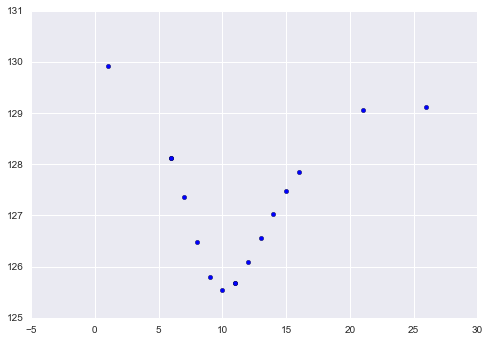

In [213]:
# Now let's try varying the size of k associated to the weights.

ks = np.arange(1, 30, 5)
ks = np.hstack((ks, np.arange(6, 16)))
model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for k in ks:
    model.set_params(pre__kw_args = {'k' : k})
    scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(k, ',', end = '')
    
plt.scatter(ks, search_scores)
plt.show()

0.0 ,0.05 ,0.1 ,0.15 ,0.2 ,0.25 ,0.3 ,0.35 ,0.4 ,0.45 ,0.5 ,0.55 ,0.6 ,0.65 ,0.7 ,0.75 ,0.8 ,0.85 ,0.9 ,0.95 ,1.0 ,1.05 ,1.1 ,1.15 ,1.2 ,1.25 ,1.3 ,1.35 ,1.4 ,1.45 ,

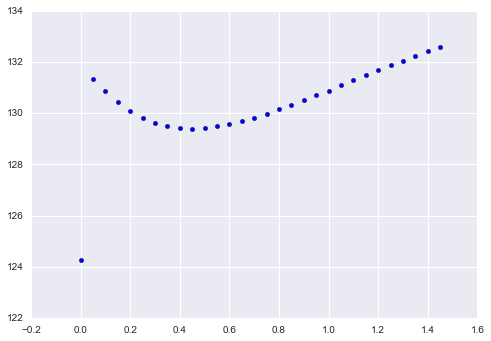

In [158]:
# Now let's try varying the size of k associated to the weights.

ks = np.arange(0, 1.5, 0.05)
model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for k in ks:
    model.set_params(pre__kw_args = {'k' : k})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(k, ',', end = '')
    
plt.scatter(ks, search_scores)
plt.show()

0.0 ,0.05 ,0.1 ,0.15 ,0.2 ,0.25 ,0.3 ,0.35 ,0.4 ,0.45 ,0.5 ,0.55 ,0.6 ,0.65 ,0.7 ,0.75 ,0.8 ,0.85 ,0.9 ,0.95 ,1.0 ,1.05 ,1.1 ,1.15 ,1.2 ,1.25 ,1.3 ,1.35 ,1.4 ,1.45 ,

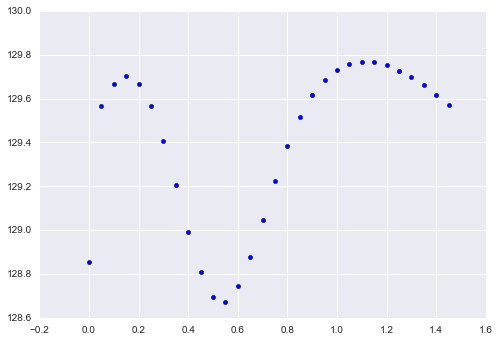

In [159]:
# Now let's try varying the size of k associated to the weights with more windows.

ks = np.arange(0, 1.5, 0.05)
model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for k in ks:
    model.set_params(pre__kw_args = {'k' : k, 'nWindows' : 6})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(k, ',', end = '')
    
plt.scatter(ks, search_scores)
plt.show()

1 , 64 ** 1 , 128 ** 1 , 192 ** 1 , 256 ** 1 , 320 ** 2 , 64 ** 2 , 128 ** 2 , 192 ** 2 , 256 ** 2 , 320 ** 3 , 64 ** 3 , 128 ** 3 , 192 ** 3 , 256 ** 3 , 320 ** 

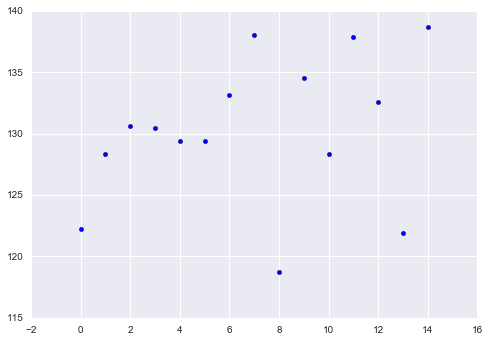

In [165]:
# Now let's try varying numer of windows and window size.

nWindows = np.arange(1, 4, 1)
sizes = np.arange(64, 64 * 6, 64)
search_space = [(x, y) for x in nWindows for y in sizes]

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for nWindow, size in search_space:
    model.set_params(pre__kw_args = {'nWindows' : nWindow, 'windowSize' : size})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(nWindow, ',', size, '** ', end = '')
    
plt.scatter(np.arange(len(search_scores)), search_scores)
plt.show()

In [166]:
print('Best parameters at ', search_space[8])

Best parameters at  (2, 256)


2 , 243 ** 3 , 162 ** 4 , 121 ** 5 , 97 ** 6 , 81 ** 7 , 69 ** 8 , 60 ** 9 , 54 ** 10 , 48 ** 11 , 44 ** 

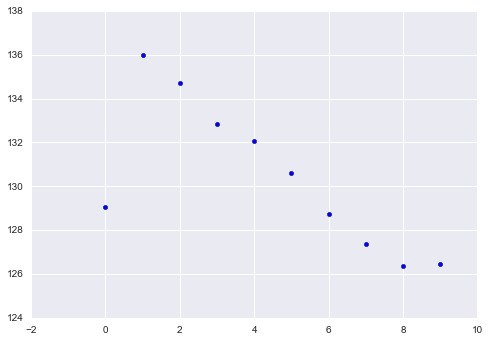

In [172]:
# Now let's vary number of nWindows while making window size be as large as possible

nWindows = np.arange(2, 12, 1)
sizes = (nTimes / nWindows).astype('int')

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for nWindow, size in zip(nWindows, sizes):
    model.set_params(pre__kw_args = {'nWindows' : nWindow, 'windowSize' : size})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(nWindow, ',', size, '** ', end = '')
    
plt.scatter(np.arange(len(search_scores)), search_scores)
plt.show()

240  241  242  243  244  245  246  247  248  249  250  251  252  253  254  255  256  257  258  259  260  261  262  263  264  265  266  267  268  269  

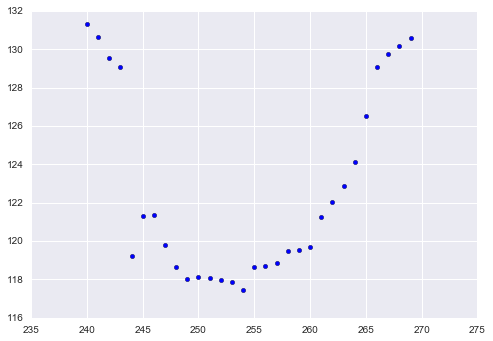

In [182]:
# Now let's search on window size for nWindows = 2.

sizes = np.arange(240, 270, 1)

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for size in sizes:
    model.set_params(pre__kw_args = {'nWindows' : 2, 'windowSize' : size})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(size, ' ', end = '')
    
plt.scatter(sizes, search_scores)
plt.show()

240  241  242  243  244  245  246  247  248  249  250  251  252  253  254  255  256  257  258  259  

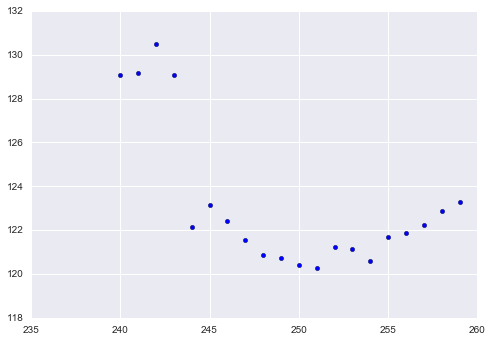

In [187]:
# Now let's search on window size for nWindows = 2.

sizes = np.arange(240, 260, 1)

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for size in sizes:
    model.set_params(pre__kw_args = {'nWindows' : 3, 'windowSize' : size})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(size, ' ', end = '')
    
plt.scatter(sizes, search_scores)
plt.show()

In [240]:
# Let's try a simple gradient search on hyper parameters for linear model. 
nSamples, nFeatures = X_train.shape

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])

params = {'nWindows' : 4, 'windowSize' : 110, 'k' : 1}
change = {'nWindows' : 1, 'windowSize' : 50, 'k' : 1.0}
niterations = 50
learnrate = np.exp(np.log(1/2) / 10)
cooling = -1 / 10 * np.log(1/2)
currentscore = 2000

results = np.empty(0)
param_results = []
for i in range(niterations):
    for key in change:
        for scale in np.arange(-1, 3, 2):
            params2 = params.copy()
            params2[key] += change[key] * scale
            if params2[key] > 0 and params2['nWindows'] * params2['windowSize'] < nFeatures:
                model.set_params(pre__kw_args = params2)
                model.fit(X_train, Y_train)
                Y_predict = model.predict(X_valid)
                score = smape(Y_predict, Y_valid)
                print(i, params2, score)
                if score < currentscore:
                    params = params2.copy()
                    currentscore = score
                else: # Do simulated annealing
                    jump = np.exp((currentscore - score) * cooling)
                    if np.random.rand() < jump:
                        params = params2.copy()
                        currentscore = score
            results = np.hstack((results, currentscore))
            param_results.append(params)
        change[key] *= learnrate
        if key != 'k':
            change[key] = np.amax([int(change[key]), 1])
                
    print('Best Score ', params, currentscore)
    print('change = ', change)
        

0 {'windowSize': 60, 'nWindows': 4, 'k': 1} 129.215955782
0 {'windowSize': 110, 'nWindows': 4, 'k': 1} 136.088158457
0 {'windowSize': 110, 'nWindows': 3, 'k': 1} 133.326681454
0 {'windowSize': 110, 'nWindows': 4, 'k': 1} 136.088158457
0 {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
Best Score  {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
change =  {'windowSize': 46, 'nWindows': 1, 'k': 0.93303299153680741}
1 {'windowSize': 64, 'nWindows': 3, 'k': 2.0} 136.263744364
1 {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
1 {'windowSize': 110, 'nWindows': 2, 'k': 2.0} 132.291386751
1 {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
1 {'windowSize': 110, 'nWindows': 3, 'k': 1.0669670084631926} 133.790536366
1 {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
Best Score  {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
change =  {'windowSize': 42, 'nWindows': 1, 'k': 0.87055056329612412}
2 {'windowSize': 68, 'nWindows': 3, 'k': 2

16 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
change =  {'windowSize': 10, 'nWindows': 1, 'k': 0.30778610333622913}
17 {'windowSize': 204, 'nWindows': 2, 'k': 2.0} 125.823231933
17 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
17 {'windowSize': 214, 'nWindows': 1, 'k': 2.0} 128.282124418
17 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
17 {'windowSize': 214, 'nWindows': 2, 'k': 1.692213896663771} 126.238995034
17 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
change =  {'windowSize': 9, 'nWindows': 1, 'k': 0.28717458874925883}
18 {'windowSize': 205, 'nWindows': 2, 'k': 2.0} 125.816104029
18 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
18 {'windowSize': 214, 'nWindows': 1, 'k': 2.0} 128.282124418
18 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
18 {'windowSize': 214, 

32 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
32 {'windowSize': 214, 'nWindows': 2, 'k': 2.1411811795879845} 125.729173394
32 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
change =  {'windowSize': 1, 'nWindows': 1, 'k': 0.10153154954452946}
33 {'windowSize': 213, 'nWindows': 2, 'k': 2.25} 125.597347208
33 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
33 {'windowSize': 214, 'nWindows': 1, 'k': 2.25} 128.248672359
33 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
33 {'windowSize': 214, 'nWindows': 2, 'k': 2.1484684504554705} 125.721014401
33 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
change =  {'windowSize': 1, 'nWindows': 1, 'k': 0.094732285406899902}
34 {'windowSize': 213, 'nWindows': 2, 'k': 2.25} 125.597347208
34 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569

48 {'windowSize': 213, 'nWindows': 2, 'k': 2.25} 125.597347208
48 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
48 {'windowSize': 214, 'nWindows': 1, 'k': 2.25} 128.248672359
48 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
48 {'windowSize': 214, 'nWindows': 2, 'k': 2.2141031764063426} 125.649280949
48 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
change =  {'windowSize': 1, 'nWindows': 1, 'k': 0.033492920704259167}
49 {'windowSize': 213, 'nWindows': 2, 'k': 2.25} 125.597347208
49 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
49 {'windowSize': 214, 'nWindows': 1, 'k': 2.25} 128.248672359
49 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
49 {'windowSize': 214, 'nWindows': 2, 'k': 2.2165070792957406} 125.646719526
49 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
ch

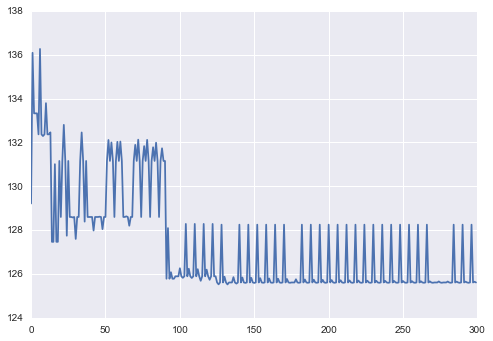

132 {'windowSize': 209, 'nWindows': 2, 'k': 2.25} 125.521668694


In [241]:
plt.plot(results)
plt.show()

bestindex = np.argmin(results)
print(bestindex, param_results[bestindex], results[bestindex])

In [189]:
print(np.arange(10).reshape(2,-1)[:,-2:4])

[[3]
 [8]]


In [201]:
# Let's just check a simple neural network.

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('normalize', StandardScaler()),
                   ('neural', MLPRegressor(hidden_layer_sizes = (6), verbose = True, learning_rate_init = 1e-2)) ])
scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
print('Cross val score = ', scores.mean(), '+-', scores.std())

Iteration 1, loss = 2987805818.31908369
Iteration 2, loss = 2985172666.56551075
Iteration 3, loss = 2983799389.53262520
Iteration 4, loss = 2982283076.22505617
Iteration 5, loss = 2980525035.49928904
Iteration 6, loss = 2978427437.63070202
Iteration 7, loss = 2975981438.53351212
Iteration 8, loss = 2973249335.25327921
Iteration 9, loss = 2970445117.03080702
Iteration 10, loss = 2967327301.32533693
Iteration 11, loss = 2963879099.37151051
Iteration 12, loss = 2960355245.33267927
Iteration 13, loss = 2956446524.48961306
Iteration 14, loss = 2952453273.25146580
Iteration 15, loss = 2948305893.27711964
Iteration 16, loss = 2943666573.81833220
Iteration 17, loss = 2939196237.53143358
Iteration 18, loss = 2934276225.40563869
Iteration 19, loss = 2929158904.93870544
Iteration 20, loss = 2923715457.25083303
Iteration 21, loss = 2918180015.69110918
Iteration 22, loss = 2912390839.59325504
Iteration 23, loss = 2906715803.04480124
Iteration 24, loss = 2900608158.26339245
Iteration 25, loss = 2894

C:\Users\Matthew\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Iteration 1, loss = 7148505624.59964180
Iteration 2, loss = 7147259793.55516720
Iteration 3, loss = 7145301866.87215328
Iteration 4, loss = 7141682107.89033318
Iteration 5, loss = 7136934204.37164307
Iteration 6, loss = 7130681523.05477142
Iteration 7, loss = 7123499608.51513863
Iteration 8, loss = 7116098166.94253349
Iteration 9, loss = 7107421138.15362549
Iteration 10, loss = 7097345463.89718914
Iteration 11, loss = 7086838506.93584156
Iteration 12, loss = 7075341291.96547031
Iteration 13, loss = 7063360623.33104420
Iteration 14, loss = 7050678509.99610710
Iteration 15, loss = 7037326552.85559082
Iteration 16, loss = 7022718140.42215919
Iteration 17, loss = 7007752273.12233829
Iteration 18, loss = 6991792527.08596420
Iteration 19, loss = 6975382708.08045101
Iteration 20, loss = 6958035058.47703838
Iteration 21, loss = 6939484900.42273712
Iteration 22, loss = 6921274016.57396507
Iteration 23, loss = 6902071338.89103794
Iteration 24, loss = 6882463490.82377243
Iteration 25, loss = 6862

Iteration 200, loss = 148178533.17960805


C:\Users\Matthew\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Iteration 1, loss = 4566063235.28149891
Iteration 2, loss = 4565595656.09659767
Iteration 3, loss = 4564466200.56378174
Iteration 4, loss = 4562835345.72904587
Iteration 5, loss = 4560811347.30529022
Iteration 6, loss = 4558058380.11143017
Iteration 7, loss = 4554914490.80049992
Iteration 8, loss = 4551386901.10291958
Iteration 9, loss = 4547522134.66480827
Iteration 10, loss = 4542990879.79736423
Iteration 11, loss = 4538381250.25422955
Iteration 12, loss = 4533239094.33239174
Iteration 13, loss = 4527777846.41449738
Iteration 14, loss = 4522045681.12915802
Iteration 15, loss = 4516160009.72713280
Iteration 16, loss = 4509708468.99828815
Iteration 17, loss = 4502454638.32597828
Iteration 18, loss = 4495144626.40233326
Iteration 19, loss = 4487856301.43782520
Iteration 20, loss = 4480487701.44921684
Iteration 21, loss = 4472588271.86770725
Iteration 22, loss = 4463786960.25109005
Iteration 23, loss = 4455199116.03758049
Iteration 24, loss = 4446425555.64814281
Iteration 25, loss = 4436

Iteration 200, loss = 584326881.67317808


C:\Users\Matthew\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Cross val score =  126.662965417 +- 4.58680608875
